# Convolutional Neural Networks: Build an image classifier using pytorch and fastai

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
from PIL import Image
from scipy import ndimage
from fastai.vision.all import *
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
np.random.seed(1)

In [2]:
class NpArrayImageDataset(Dataset):
    def __init__(self, img_arr, label_arr, transform):
        self.img_arr = img_arr
        self.label_arr = label_arr
        self.transform = transform

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, index):
        if self.transform:            
            tfmd_img = self.transform(self.img_arr[index])
            # ToTensor transformation causes the RGB channel dimension to shift from index 2 to 0
            # we interchange the dimensions at index 0 and 2 to move channel dim back to index 2
        #return (tfmd_img.transpose(0,2), self.label_arr[index])
        return (tfmd_img, self.label_arr[index])

Run the next cell to load the "SIGNS" dataset you are going to use.

In [3]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape)
print(test_x.shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)


In [4]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=5, X=train_x, y=train_y)
fold1 = train_y[k_folds == 1] 

There are 1080 images of dimension 64 by 64 by 3 in train dataset

In [5]:
def get_imgs_mean_stddev(imgs, axis=None):    
    """Get the mean and standard deviation for images in a dataset / mini-batch
    Args:
        imgs ([2d or 3d numpy array]): images in collection (with no to_tensor transformation applied)
        axis ([tuple of ints], optional): Axis along which mean and std dev is to be calculated.
        Defaults to None.
    Returns:
        [tuple]: tuple of tensors with mean and std.dev. of the imgs
    """
    to_tensor = transforms.ToTensor()
    img_tensor_arr = [to_tensor(img) for img in train_x]
    # stack will arrange the tensors one over the other with dim=0 being the new dimension that  
    # stores the number of tensors stacked. This new dimension can be placed at any index
    img_tensor_arr = torch.stack(img_tensor_arr)
    if axis is not None:
        return torch.mean(img_tensor_arr, axis=axis), torch.std(img_tensor_arr, axis=axis)
    else:            
        return torch.mean(img_tensor_arr, axis=(0, 2, 3)), torch.std(img_tensor_arr, axis=(0,2,3))
    
train_img_mean, train_img_std = get_imgs_mean_stddev(train_x)        
print(train_img_mean, train_img_std)

tensor([0.7630, 0.7105, 0.6634]) tensor([0.1538, 0.1998, 0.2221])


In [6]:
img_transforms = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(train_img_mean, train_img_std)])

# Get the train and validation data loaders for a specific fold. 
# X: numpy array of input features
# y: numpy array of target labels
# fold: fold index for which to create data loaders                                     
# kfolds: Array that marks each of the data items as belonging to a specific fold
def get_fold_dls(fold, kfolds, X, y):                         
    train_X = X[kfolds != fold]        
    train_y = y[kfolds != fold]    
    val_X = X[kfolds == fold]
    val_y = y[kfolds == fold]
    ds_train_signs = NpArrayImageDataset(train_X, train_y, transform=img_transforms)
    ds_val_signs = NpArrayImageDataset(val_X, val_y, transform=img_transforms)
    dl_train = DataLoader(ds_train_signs, batch_size=64, shuffle=True)
    dl_val = DataLoader(ds_val_signs, batch_size=64, shuffle=True)
    return dl_train, dl_val

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="../images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

Image label = 5


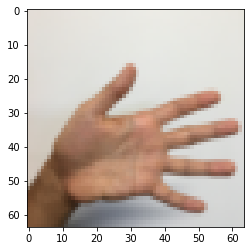

In [7]:
# display an untransformed image
plt.imshow(train_x[0])
print(f"Image label = {train_y[0]}")

## Pipeline in fastai

Pipeline is a wrapper for compose_tfms. You can pass instances of Transform or regular functions in funcs, the Pipeline will wrap them all in Transform (and instantiate them if needed) during the initialization. It handles the transform setup by adding them one at a time and calling setup on each, goes through them in order in __ call __ or decode and can show an object by applying decoding the transforms up until the point it gets an object that knows how to show itself.

In [8]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

# ItemTransform always takes tuples as items
class SignsTransform(ItemTransform):    
    # By passing data to the transform we can make it infer its from the data. This is done in setups method which
    # is called when transforms initialization happens during pipeline creation.
    def setups(self, items):
        # items is a tuple of input images and target label collections        
        self.img_arr = items[0]
        self.label_arr = items[1]
        self.img_tfm = Pipeline([PILImage.create, ToTensor()])
        # vocab is a list of unique target labels
        # o2i is a dictionary mapping a target label to an integer index. The model uses the integer indexes as the targets
        self.vocab, self.o2i = uniqueify(self.label_arr, sort=True, bidir=True)
        self.img_cat = Categorize(self.vocab)

    def encodes(self, index):
        return self.img_tfm(self.img_arr[index]), self.img_cat(self.label_arr[index])

    def decodes(self, x):
        return TitledImage(x[0], self.vocab[x[1]])

<AxesSubplot:>

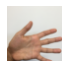

In [9]:
#img = PILImage.create(train_x[0])
#tns_img = ToTensor()(img)
img_pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), FlipItem(p=1), DihedralItem(), RandomCrop(56)])
img = img_pipe(train_x[0])
show_image(img)

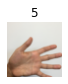

In [10]:
# Display an image with its corresponding label
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

TitledImage(img, 5).show()    

## TfmdLists vs Datasets in fastai

A Pipeline combined with a collection is a TfmdLists in fastai.The main difference between TfmdLists and Datasets is the number of Pipelines you have: TfmdLists take one Pipeline to transform a list (like we currently have) whereas Datasets combines several Pipelines in parallel to create a tuple from one set of raw items, for instance a tuple (input, target).

One pipeline makes a TfmdLists. Creating a TfmdLists just requires a list of items and a list of transforms that will be combined in a Pipeline:

tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])<br>
x,y = tls[0]<br>
x.shape,y<br>

Output -> (torch.Size([3, 224, 224]), 21)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


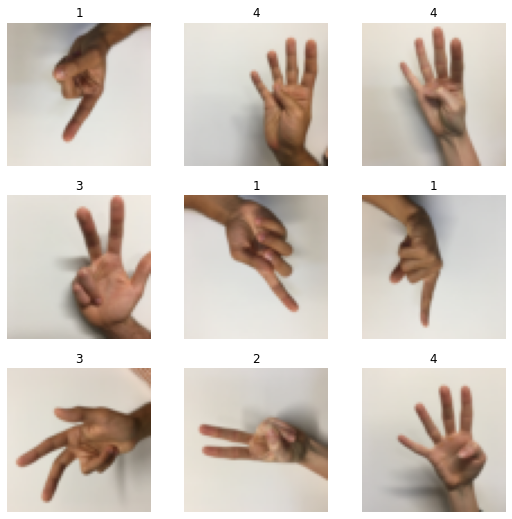

In [17]:
def get_fastai_fold_dls(fold, kfolds, X, y):    
    signs_tfm = SignsTransform()
    signs_tfm.setup((X, y))
    items = np.array(range(len(X)))
    val_index = items[kfolds == fold+1]    
    train_index = items[kfolds != fold]
    # split the data into train and val randomly. Default is 20% val and 80% train.
    #splits = RandomSplitter()(items) 
    # numpy array needs to be converted to python list as L works on plain lists
    splits = L(train_index.tolist()), L(val_index.tolist())
    # TfmdLists has an 's' in its name because it can represent several transformed lists: your training and validation sets. 
    # To use that functionality, we just need to pass splits to the initialization. splits should be a list of lists of indices (one list per set). 
    # To help create splits, we can use all the splitters of the fastai library
    tl = TfmdLists(items, Pipeline([signs_tfm]), splits=splits)
    
    # Then your tls get a train and valid attributes (it also had them before, but the valid was empty and the train contained everything).
    # tl_train = tl.train # tl.subset(0)
    # tl_valid = tl.valid # tl.subset(1)
    # Two ways to display an item at a specific index from a TfmdList. This makes use of the decodes function in transforms
    # show_at(tl, 7)
    # x, y = tl[7]
    # tl.show((x, y))

    # Getting dataloaders from a TfmdList. We apply two transforms at batch level (on GPU). Normalize and IntToFloatTensor
    # as augmentation transforms of fastai on the GPU require float tensors
    item_tfms = [DihedralItem(), FlipItem(p=0.5)]
    batch_tfms = [Normalize.from_stats(train_img_mean, train_img_std), IntToFloatTensor()] #, RandomResizedCropGPU(size=56)]
    dls = tl.dataloaders(bs=64, val_bs=64, after_item=item_tfms, after_batch=batch_tfms)    
    return dls

dls = get_fastai_fold_dls(0, k_folds, train_x, train_y)    
dls.show_batch()

## Using Datasets
Datasets applies a list of list of transforms (or list of Pipelines) lazily to items of a collection, creating one output per list of transforms/Pipeline. To create a Datasets, we then pass two pipelines of transforms, one for the input and one for the target:

tfms = [ [PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()], [labeller, Categorize()] ]<br>
dsets = Datasets(items, tfms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

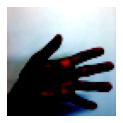

In [12]:
# display the same image but this time transformed
tfmd_img = img_transforms(train_x[0])
show_image(tfmd_img)

## Build a convolution net. We are inspired by the classic LeNet architecture

In [13]:
class LeNet(nn.Module):
    def __init__(self, input_ch, out_class_count):
        super().__init__()
        # no of channels in input image. Input image is of shape (64, 64, 3)
        self.input_ch = input_ch
        # no of unique output class labels
        self.out_class_count = out_class_count
        # The first convolution layer
        self.conv1 = nn.Sequential(
            # use 10 in place of 6 as the no of out channels in first convolution layer to increase
            # network performance
            nn.Conv2d(in_channels=input_ch, out_channels=10, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        # output from first conv layer has shape (15, 15, 20)
        # second convolution layer
        self.conv2 = nn.Sequential(
            # use 25 in place of 16 (as per original network architecture) as the 
            # no of out channels in 2nd convolution layer to increase network performance
            nn.Conv2d(in_channels=10, out_channels=25, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        # output from 2nd conv layer has dim (3, 3, 50). 
        self.conv3 = nn.Sequential(
            # use 50 in place of 16 (as per original network architecture) as the 
            # no of out channels in 2nd convolution layer to increase network performance
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        # output from 3rd conv layer has shape (4, 4, 50)
        self.fc1 = nn.Linear(in_features=800, out_features=200)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=200, out_features=out_class_count)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size = x.shape[0]        
        x = self.conv1(x)        
        x = self.conv2(x)
        x = self.conv3(x)        
        # flatten the output from the last conv layer into 1d tensor        
        x = x.view(batch_size, -1)        
        x = self.fc1(x)        
        x = self.relu1(x)
        x = self.fc2(x)
        output = self.logsoftmax(x)
        return output

In [14]:
# CONSTANTS 
NUM_FOLDS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

model = LeNet(3, 6).to(DEVICE)

In [15]:
def get_fold_dls(fold, kfolds, X, y):
    train_X = X[kfolds != fold+1]
    train_y = y[kfolds != fold+1]    
    valid_X = X[kfolds == fold+1]
    valid_y = y[kfolds == fold+1]
    #print(len(train_X), len(train_y), len(valid_X), len(valid_y))
    ds_train = NpArrayImageDataset(train_X, train_y, img_transforms)
    ds_valid = NpArrayImageDataset(valid_X, valid_y, img_transforms)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True)
    return dl_train, dl_valid

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
FOLD  0


epoch,train_loss,valid_loss,accuracy,time
0,1.774872,1.727539,0.250000,00:05
1,1.716959,1.600482,0.240741,00:05
2,1.660762,1.570886,0.379630,00:05
3,1.636930,1.550774,0.388889,00:05
4,1.627952,1.560493,0.300926,00:05
5,1.574454,1.456196,0.421296,00:05
6,1.486135,1.155915,0.523148,00:05
7,1.399888,1.222064,0.462963,00:05
8,1.308158,1.023630,0.569444,00:05
9,1.202350,0.955537,0.597222,00:05


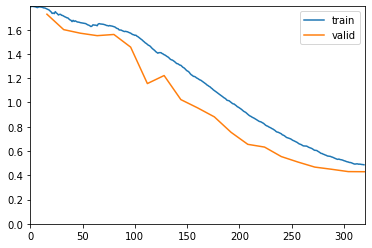

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
FOLD  1


epoch,train_loss,valid_loss,accuracy,time
0,0.392128,0.423723,0.847222,00:04
1,0.376531,0.427783,0.847222,00:04
2,0.422767,0.400099,0.865741,00:04
3,0.448289,0.516788,0.800926,00:04
4,0.474898,0.590142,0.763889,00:04
5,0.494416,0.493256,0.805556,00:04
6,0.506633,0.685922,0.726852,00:04
7,0.544066,0.537884,0.800926,00:04


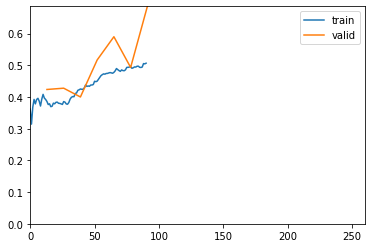

No improvement since epoch 2: early stopping
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
FOLD  2


epoch,train_loss,valid_loss,accuracy,time
0,0.419964,0.520764,0.805556,00:05
1,0.403479,0.458468,0.865741,00:04
2,0.372389,0.419421,0.856481,00:04
3,0.407097,0.600433,0.805556,00:04
4,0.418190,0.808208,0.712963,00:04
5,0.443756,0.546988,0.773148,00:04
6,0.447958,0.499317,0.828704,00:04
7,0.442190,0.465581,0.824074,00:04


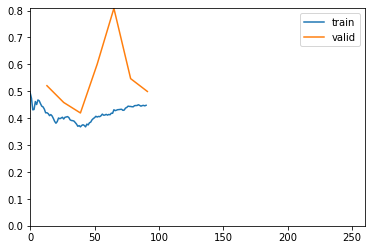

No improvement since epoch 2: early stopping
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
FOLD  3


epoch,train_loss,valid_loss,accuracy,time
0,0.335816,0.295393,0.912037,00:04
1,0.337768,0.212614,0.944444,00:04
2,0.313857,0.216339,0.921296,00:04
3,0.344232,0.320634,0.856481,00:05
4,0.358629,0.823778,0.740741,00:05
5,0.400515,0.540065,0.847222,00:05
6,0.435610,0.488233,0.814815,00:04


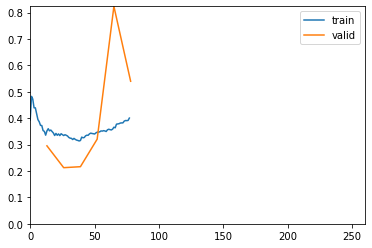

No improvement since epoch 1: early stopping
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
FOLD  4


epoch,train_loss,valid_loss,accuracy,time
0,0.351828,0.289057,0.884259,00:04
1,0.311298,0.221446,0.916667,00:04
2,0.287232,0.286689,0.893519,00:04
3,0.293982,0.535473,0.819444,00:03
4,0.358909,0.443543,0.837963,00:04
5,0.419179,0.889171,0.708333,00:04
6,0.453974,0.369261,0.861111,00:04


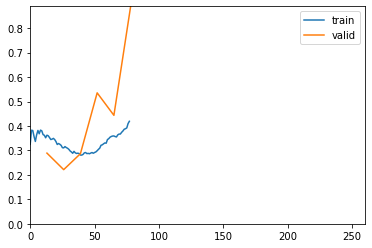

No improvement since epoch 1: early stopping


In [18]:
# instantiate the model
# define the loss function, optimizer, hyperparameters and metrics to measure model performance
from fastai.data.core import DataLoaders
from fastai.optimizer import OptimWrapper
from torch import optim 
from functools import partial
from fastai.callback.schedule import Learner
from fastai.metrics import accuracy
import torch.nn.functional as F

for fold in range(NUM_FOLDS):
    #dl_train, dl_valid = get_fold_dls(fold, k_folds, train_x, train_y)
    #dls = DataLoaders(dl_train, dl_valid)
    dl = get_fastai_fold_dls(fold, k_folds, train_x, train_y)
    dls = DataLoaders(dl.train, dl.valid)
    opt_func = partial(OptimWrapper, opt=optim.Adam)
    learn = Learner(dls, model, loss_func=F.nll_loss, opt_func=opt_func, metrics=accuracy)
    #learn.summary()
    print(f"FOLD  {fold}")
    learn.fit_one_cycle(n_epoch=20, lr_max=1e-2, 
                        cbs=[ShowGraphCallback(), EarlyStoppingCallback(patience=8), CSVLogger()])
    learn.save(f"model_fold{fold}", with_opt=False)    

## How model ensembles are almost always better than a single model

In [ ]:
def voting_ensemble_prediction(models, input_img):
    preds = torch.zeros(6)
    for model in models:
        pred = int(torch.argmax(model(input_img)))
        preds[pred] += 1
    return int(torch.argmax(preds))     

def predict_label(models, input_img, best_model_index=None):
    if best_model_index == None:
        return voting_ensemble_prediction(models, input_img)
    else:
        return int(torch.argmax(models[best_model_index](input_img)))       

In [ ]:
# perform inference on test set using the voting ensemble of models created in each of the CV folds
models = []
for fold in range(NUM_FOLDS):
    model = LeNet(3, 6)
    model_state_dict = torch.load(f"./models/model_fold{fold}.pth")
    model.load_state_dict(model_state_dict)
    models.append(model)

def run_test_predictions(models, best_model_index=None):
    ds_test_signs = NpArrayImageDataset(test_x, test_y, transform=img_transforms)
    incorrect_preds = []
    for img, label in ds_test_signs:    
        with torch.no_grad():            
            img = img.unsqueeze(0)
            pred_label = predict_label(models, img, best_model_index)
            actual_label = int(label)        
            if actual_label != pred_label: incorrect_preds.append((actual_label, pred_label))        
    accuracy = (len(ds_test_signs) - len(incorrect_preds)) / len(ds_test_signs)       
    print(f"Test accuracy = {accuracy * 100}%")
    print(f"Incorrect predictions = {len(incorrect_preds)} ")
    for item in incorrect_preds:
        print(f"Actual label = {item[0]}, Predicted label = {item[1]}")

run_test_predictions(models)        

Test accuracy = 90.83333333333333%
Incorrect predictions = 11 
Actual label = 5, Predicted label = 4
Actual label = 2, Predicted label = 1
Actual label = 2, Predicted label = 1
Actual label = 4, Predicted label = 3
Actual label = 2, Predicted label = 1
Actual label = 2, Predicted label = 1
Actual label = 5, Predicted label = 4
Actual label = 5, Predicted label = 3
Actual label = 2, Predicted label = 1
Actual label = 5, Predicted label = 4
Actual label = 3, Predicted label = 1


In [ ]:
# Now try a single model with the minimum validation loss in cross validation
run_test_predictions(models, 2)

Test accuracy = 90.0%
Incorrect predictions = 12 
Actual label = 5, Predicted label = 4
Actual label = 5, Predicted label = 4
Actual label = 2, Predicted label = 1
Actual label = 1, Predicted label = 3
Actual label = 2, Predicted label = 1
Actual label = 2, Predicted label = 1
Actual label = 5, Predicted label = 3
Actual label = 5, Predicted label = 3
Actual label = 1, Predicted label = 3
Actual label = 2, Predicted label = 1
Actual label = 5, Predicted label = 3
Actual label = 5, Predicted label = 4


## Ensembling boosts the accuracy by about 1.7%. Not bad